Necessary imports and styling

In [2]:
import csv
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker


plt.style.use("ggplot")

# Weight anaylisis

Storing teams data entries from csv file

In [4]:
# Var ini
info = "FSAE_2023_results/FSAE_2023_results - Team information.csv"
acc = "FSAE_2023_results/FSAE_2023_results - Acceleration event results.csv"
skid = "FSAE_2023_results/FSAE_2023_results - Skidpad event results.csv"
cross = "FSAE_2023_results/FSAE_2023_results - Autocross event results.csv"

# Entries are composed of {"category" : [list of weights]}
entries = dict()
# Data is a dict of dicts with the following keys:
# * "car": car number (Main key):
# {
# - "weight" : weight
# - "acc" : acceleration time
# - "coll" : list of points per event for calculation only, is removed after calculation
# - "points" : total points
# }

data = {}

# Opening info file with context manager and parsing it with csv module
with open(info) as file:
    reader = csv.DictReader(file, restval = "help")

    for entry in reader:
        # Get displacement and weight, casting the latter
        displacement = entry["Engine Displacement (cc)"]
        car_num = entry["CarNum"]
        # If it's not a valid value, then it'll skip to the next entry
        try:
            weight = float(entry["Weight(kg)"])
        except ValueError:
            continue

        # Storing displacement entry 
        if displacement not in entries:
            entries[displacement] = list()
        
        # Storing data per entry
        entries[displacement].append(weight)
        data[car_num] = {"weight": weight, "acc": 0, "coll": [], "points": 0}

# Casting collections and TOTAL into np.array for ease of calculation
for category in entries:
    entries[category] = np.array(entries[category])

total = np.array([data[car]["weight"] for car in data])

# TODO: Add acceleration and whole performance points
# Opening acceleration file with context manager and parsing it with csv module
with open(acc) as file:
    reader = csv.DictReader(file, restval = "help")

    for entry in reader:
        car_num = entry["CarNum"]
        # If it's not a valid value, then it'll skip to the next entry
        try:
            acc_time = float(entry["Best time"])
            acc_points = float(entry["Score"])
        except ValueError:
            continue

        # Storing acceleration time
        if car_num in data:
            data[car_num]["acc"] = acc_time
            data[car_num]["coll"].append(acc_points)

# Opening skidpad file with context manager and parsing it with csv module
with open(skid) as file:
    reader = csv.DictReader(file, restval = "help")

    for entry in reader:
        car_num = entry["CarNum"]
        # If it's not a valid value, then it'll skip to the next entry
        try:
            skid_points = float(entry["Score"])
        except ValueError:
            continue

        # Storing skidpad points
        if car_num in data:
            data[car_num]["coll"].append(skid_points)

# Opening autocross file with context manager and parsing it with csv module
with open(cross) as file:
    reader = csv.DictReader(file, restval = "help")

    for entry in reader:
        car_num = entry["CarNum"]
        # If it's not a valid value, then it'll skip to the next entry
        try:
            cross_points = float(entry["Score"])
        except ValueError:
            continue

        # Storing autocross points
        if car_num in data:
            data[car_num]["coll"].append(cross_points)


# Calculating total points && Cleaning data from cars that didn't participate in 
# acceleration, skidpad or autocross
# (Usually the latter is due to the car not being ready for the event, rather than a performance issue)
for car in list(data):
    if len(data[car]["coll"]) < 3:
        del data[car]
    else:
        data[car]["points"] = sum(data[car]["coll"])
        data[car].pop("coll")


Computing averages, deviation and plotting them

AVERAGE WEIGHT PER ENGINE DISPLACEMENT
Category: Average, Cars 
     250:  254.50,    1
     300:  245.40,    1
     320:  187.30,    1
     450:  184.38,   17
     470:  212.30,    1
     478:  166.95,    2
     500:  204.70,    3
     600:  226.30,   61
     625:  248.10,    1
     627:  186.40,    1
     636:  226.21,    8
     650:  234.30,    2
     670:  213.60,    1
     675:  216.67,    3
     689:  199.10,    1
     690:  212.73,    7
     700:  218.60,    1
   TOTAL:  216.69±31.97,  112


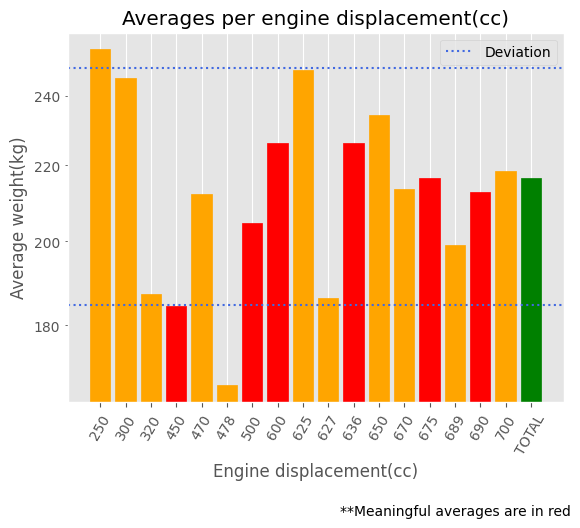

In [11]:
# Avrg computing
averages = dict()

# Storing averages and amount of cars per category for classification
for category in entries:
    averages[category] = (np.mean(entries[category]), len(entries[category]))

averages["TOTAL"] = (np.mean(total), len(total))

# Computing deviation
s = np.sqrt(np.sum((total - averages["TOTAL"][0])**2)/len(data))

print("AVERAGE WEIGHT PER ENGINE DISPLACEMENT", "Category: Average, Cars ", sep="\n")
for category in sorted(averages):
    if category != "TOTAL":
        print(f"{category:>8}: {averages[category][0]:>7.2f}, {averages[category][1]:>4}")
    if category == "TOTAL":
        print(f"{category:>8}: {averages[category][0]:>7.2f}±{s:.2f}, {averages[category][1]:>4}")

# Plotting
fig, ax = plt.subplots()

# Clearing invalid data
# averages = {key: value for key, value in averages.items() if value[1] >= 3}

X = np.arange(len(averages))
Y = np.array([averages[category][0] for category in sorted(averages)])

barlist = ax.bar(X, Y)
plt.axhline(averages["TOTAL"][0]+s, color="royalblue", linestyle=":", label="Deviation")
plt.axhline(averages["TOTAL"][0]-s, color="royalblue", linestyle=":")

# Formatting plot
plt.legend(loc="upper right")
ax.set_title("Averages per engine displacement(cc)")
ax.set_xlabel("Engine displacement(cc)")
ax.set_ylabel("Average weight(kg)")
plt.figtext(0.55, -0.125, "**Meaningful averages are in red")


ax.set_yscale("log")
ax.yaxis.set_minor_formatter(ticker.ScalarFormatter())

x_ticks = sorted([key for key in averages.keys()])
ax.set_xticks(np.arange(len(x_ticks)) ,labels=x_ticks)
plt.xticks(rotation=60)

# Coloring based on valid data
for i, key in enumerate(sorted(averages)):
    if  averages[key][1] < 3:
        barlist[i].set_color('orange')
    else:
        barlist[i].set_color('red')
barlist[-1].set_color('green')


Weight-Performance analysis

Mean acceleration time: 5.041499999999999
Mean total points: 165.1248717948718


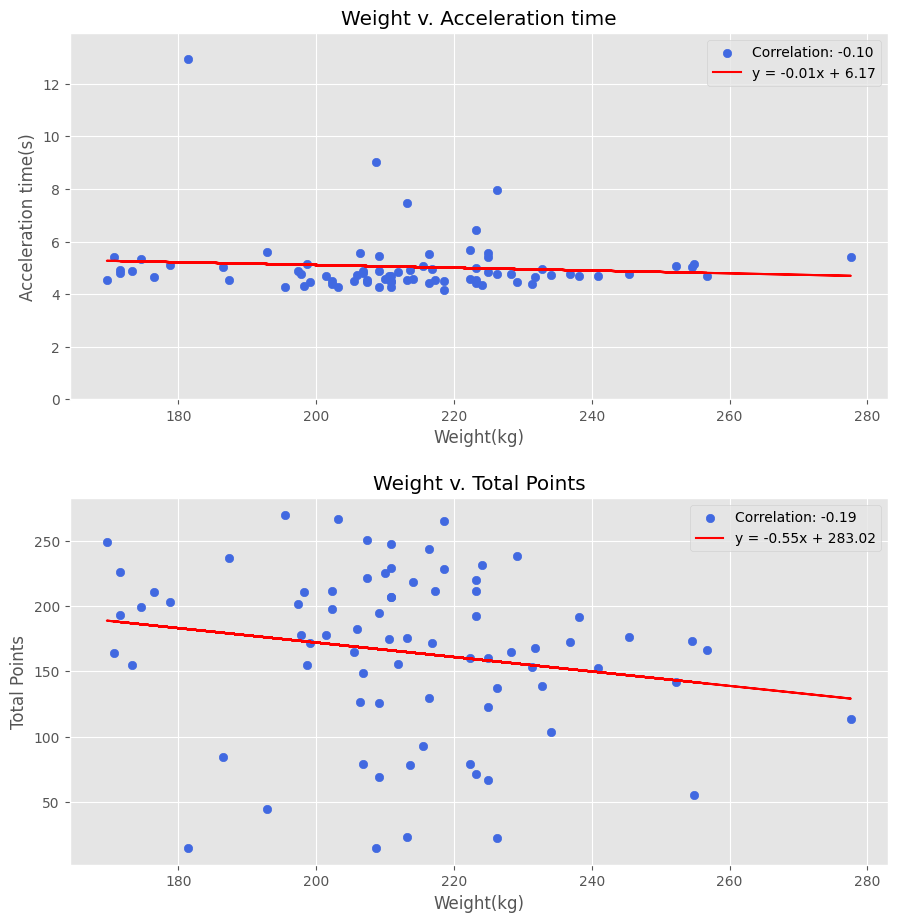

In [12]:
# Computing correlation
X = np.array([data[car]["weight"] for car in data])
# Weight-Acceleration time
Y1 = np.array([data[car]["acc"] for car in data])
R1 = np.corrcoef(X, Y1)[0,1]
M1 = np.mean(Y1)

# Weight-Total Points
Y2 = np.array([data[car]["points"] for car in data])
R2 = np.corrcoef(X, Y2)[0,1]
M2 = np.mean(Y2)


# Linear Regression (Least squares)
# Weight-Acceleration time
m1, b1 = np.polyfit(X, Y1, 1)
# Weight-Total Points
m2, b2 = np.polyfit(X, Y2, 1)


# Plot
# Create both plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
fig.tight_layout(pad=5.0)

# Plot Weight-Acceleration time and its function
ax1.scatter(X, Y1, color="royalblue", label=f"Correlation: {R1:.2f}")
ax1.plot(X, m1*X + b1, color="red", label=f"y = {m1:.2f}x + {b1:.2f}")

# Plot Weight-Total Points and its function
ax2.scatter(X, Y2, color="royalblue", label=f"Correlation: {R2:.2f}")
ax2.plot(X, m2*X + b2, color="red", label=f"y = {m2:.2f}x + {b2:.2f}")

# Formatting plots
# Weight-Acceleration time
ax1.set_title("Weight v. Acceleration time")
ax1.set_ylabel("Acceleration time(s)")
ax1.set_xlabel("Weight(kg)")
ax1.set_ylim(0, max(Y1)+1)
ax1.legend(loc="upper right")

# Weight-Total Points
ax2.set_title("Weight v. Total Points")
ax2.set_ylabel("Total Points")
ax2.set_xlabel("Weight(kg)")
ax2.legend(loc="upper right")

print("Mean acceleration time:", M1)
print("Mean total points:", M2)
plt.show()
